<style>

    .rst-content blockquote {

        margin-left: 0px;

    }

   

    blockquote > div {

        margin: 1.5625em auto;

        padding: 20px 15px 1px;

        border-left: 0.2rem solid rgb(59, 136, 219);  

        border-radius: 0.2rem;

        box-shadow: 0 0.2rem 0.5rem rgb(0 0 0 / 5%), 0 0 0.0625rem rgb(0 0 0 / 10%);

    }

</style>

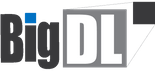

# Vision Transformer Examples for InferenceOptimizer

Today, vision Transformer is becoming more and more popular. On one hand, people are constantly searching for larger pre-training corpus and pre-training model, on the other hand, how to deploy the vision transformer in the industrial scene is also a very sought-after issue.

Here we take several popular vision Transformer architectures as examples to demonstrate how to use InferenceOptimizer in BigDL-Nano to accelerate model's inference speed.

##  step 0 : Prepare the environment
We recommend you to use [Miniconda](https://docs.conda.io/en/latest/miniconda.html) to prepare the environment.

**Note**: during your installation, there may be some warnings or errors about version, just ignore them.
```bash
conda create -n nano python=3.7 setuptools=58.0.4 # "nano" is conda environment name, you can use any name you like.
conda activate nano
pip install --pre --upgrade bigdl-nano[pytorch,inference]  # install the nightly-bulit version
# install timm package to use pre-trained model
pip install timm
```

Initialize environment variables with script `bigdl-nano-init` installed with bigdl-nano.

```bash
source bigdl-nano-init
``` 

You may find environment variables set like follows:

```
conda dir found: /opt/anaconda3/envs/nano/bin/..
OpenMP library found...
Setting OMP_NUM_THREADS...
Setting OMP_NUM_THREADS specified for pytorch...
Setting KMP_AFFINITY...
Setting KMP_BLOCKTIME...
Setting MALLOC_CONF...
Setting LD_PRELOAD...
nano_vars.sh already exists
+++++ Env Variables +++++
LD_PRELOAD=/opt/anaconda3/envs/nano/bin/../lib/libiomp5.so /opt/anaconda3/envs/nano/lib/python3.7/site-packages/bigdl/nano//libs/libtcmalloc.so
MALLOC_CONF=
OMP_NUM_THREADS=112
KMP_AFFINITY=granularity=fine
KMP_BLOCKTIME=1
TF_ENABLE_ONEDNN_OPTS=1
ENABLE_TF_OPTS=1
NANO_TF_INTER_OP=1
+++++++++++++++++++++++++
Complete.
```

## step 1 : Prepare Dataset

As InferenceOptimizer needs validation data to calculate accuracy metric, we need to download [ImageNet validation dataset](https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar) and [development kit](https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz), and place them under directory `./img_data`.

Here we provide a helper function `create_imagenet_val_dataset` to help users create a subset of ImageNet validation dataset.

In [1]:
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader, Subset
import torch
import numpy as np

def create_imagenet_val_dataset(limit_num_samples=None):
    dataset = ImageNet(root="img_data", split="val")
    if limit_num_samples is not None:
        indices = np.random.permutation(len(dataset))[:limit_num_samples]
        dataset = Subset(dataset, indices)
    return dataset

## step 2 : Import related package

[PyTorch Image Models (timm)](https://github.com/rwightman/pytorch-image-models) provides a collection of image models. Here we use some vision Transformer models with pre-trained weights provided by timm to demonstrate acceleration of InferenceOptimizer in BigDL-Nano. 

In [ ]:
from bigdl.nano.pytorch import InferenceOptimizer
import timm
from torchmetrics import Accuracy

## step 3 : Define dataloader, model then optimize and get_best_model
> 📝 **Note**
>
> Actually we highly recommand users pass real training dataloader to `training_data` for calibration of quantization. But as ImageNet training set is too large to download, we just use validation dataset as faked training dataset in blow cases.
> 
> If you want to get real performance on ImageNet validation set, you can just set `limit_num_samples=None`. Here we choose a subset to make inference pipeline faster and we just want to get a rough metric to evaluate the effect of quantization.
> 
> Below results is obtained on a Cooper Lake processor with 112 physical cores.

### 1. MobileViT

[MobileViT](https://arxiv.org/abs/2110.02178) is a light-weight, general-purpose, and mobile-friendly vision Transformer.

In [3]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
faked_train_dataloader = create_loader(fake_train_dataset,
                                       input_size=256,
                                       # in case we want to evaluate single sample latency, so set batch_size to 1
                                       batch_size=1,
                                       use_prefetcher=False,
                                       no_aug=True,
                                       crop_pct=0.9,
                                       interpolation="bicubic",
                                       mean=(0.0, 0.0, 0.0),
                                       std=(1.0, 1.0, 1.0),
                                       persistent_workers=False)

val_dataset = create_imagenet_val_dataset(limit_num_samples=320)
val_dataloader = create_loader(val_dataset,
                               input_size=256,
                               batch_size=32,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.0, 0.0, 0.0),
                               std=(1.0, 1.0, 1.0),
                               persistent_workers=False)
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

> 📝 **Note**
>
> Each model has its own data preprocessing and these parameters for data loader is found in timm.
> 
> `val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform` is used to apply transform on subset dataset.

#### Calculate latency using 1 thread

In [ ]:
model = timm.create_model("mobilevit_xxs", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=1)

By calling `optimizer.summary()`, you can see the complete optimization results.

In [5]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    24.833    |        0.656         |
|           fp32_ipex            |      successful      |    26.223    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |      successful      |   174.994    |        0.666         |
|              int8              |      successful      |    25.756    |        0.003         |
|            jit_fp32            |      successful      |    20.159    |    not recomputed    |
|         jit_fp32_ipex          |      successful      |    19.678    |    not recomputed    |
|  jit_fp32_ipex_channels_last   |      su

After `optimizer.optimize`, you need to call `get_best_model()` to obtain an accelarated model which meet certain restrictions.

In [6]:
acc_model, option = optimizer.get_best_model(accuracy_criterion=0.05)
print("When accuracy drop less than 5%, the model with minimal latency is: ", option)

When accuracy drop less than 5%, the model with minimal latency is:  openvino 


Then You can use the accelarated model as normal nn.Module.

In [7]:
with InferenceOptimizer.get_context(acc_model):
    input_sample = next(iter(val_dataloader))[0]
    target = acc_model(input_sample).argmax()

#### calculate latency using 8 threads

In [ ]:
model = timm.create_model("mobilevit_xxs", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=8)

In [9]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    27.307    |        0.656         |
|           fp32_ipex            |      successful      |    28.656    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |    early stopped     |   388.867    |         None         |
|              int8              |      successful      |    25.721    |        0.003         |
|            jit_fp32            |      successful      |    23.366    |    not recomputed    |
|         jit_fp32_ipex          |      successful      |    22.259    |    not recomputed    |
|  jit_fp32_ipex_channels_last   |      su

### 2. PoolFormer

[PoolFormer](https://arxiv.org/abs/2111.11418) verifys that the general architecture of the Transformers, instead of the specific token mixer module, is more essential to the model's performance.

In [10]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
faked_train_dataloader = create_loader(fake_train_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataset = create_imagenet_val_dataset(limit_num_samples=320)
val_dataloader = create_loader(val_dataset,
                               input_size=224,
                               batch_size=32,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

#### calculate latency using 1 thread

In [ ]:
model = timm.create_model("poolformer_s12", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=1)

In [12]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    49.345    |        0.756         |
|           fp32_ipex            |      successful      |    51.116    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |    early stopped     |   1017.334   |         None         |
|              int8              |   fail to convert    |     None     |         None         |
|            jit_fp32            |    early stopped     |   447.881    |         None         |
|         jit_fp32_ipex          |    early stopped     |   454.322    |         None         |
|  jit_fp32_ipex_channels_last   |    earl

#### calculate latency using 4 threads

In [ ]:
model = timm.create_model("poolformer_s12", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=4)

In [14]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    23.68     |        0.756         |
|           fp32_ipex            |      successful      |    22.179    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |    early stopped     |   576.108    |         None         |
|              int8              |   fail to convert    |     None     |         None         |
|            jit_fp32            |    early stopped     |   434.256    |         None         |
|         jit_fp32_ipex          |    early stopped     |   445.771    |         None         |
|  jit_fp32_ipex_channels_last   |    earl

### 3. Swin Transformer

[Swin Transformer](https://arxiv.org/abs/2103.14030) proposes hierarchical vision Transformer using shifted windows.

> ⚠️ **Warning**
>
> Swin don't support dynamic batch, so the batch_size of faked_train_dataloader must be the same with val_dataloader.
>
> Otherwise the accuracy will be very low.

In [15]:
from configparser import Interpolation
from timm.data.loader import create_loader

fake_train_dataset = create_imagenet_val_dataset()
faked_train_dataloader = create_loader(fake_train_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataset = create_imagenet_val_dataset(limit_num_samples=20)
val_dataloader = create_loader(val_dataset,
                               input_size=224,
                               batch_size=1,
                               use_prefetcher=False,
                               no_aug=True,
                               crop_pct=0.9,
                               interpolation="bicubic",
                               mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225),
                               persistent_workers=False)
val_dataloader.dataset.dataset.transform = val_dataloader.dataset.transform

#### calculate latency using 1 thread

In [ ]:
model = timm.create_model("swin_base_patch4_window7_224", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=1)

In [17]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |   317.182    |         0.8          |
|           fp32_ipex            |      successful      |   317.513    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |    early stopped     |   877.588    |         None         |
|              int8              |      successful      |   181.608    |         0.85         |
|            jit_fp32            |      successful      |    282.91    |    not recomputed    |
|         jit_fp32_ipex          |      successful      |   291.576    |    not recomputed    |
|  jit_fp32_ipex_channels_last   |      su

#### calculate latency using 8 threads

In [ ]:
model = timm.create_model("swin_base_patch4_window7_224", pretrained=True)

optimizer = InferenceOptimizer()
optimizer.optimize(model,
                   training_data=faked_train_dataloader,
                   validation_data=val_dataloader,
                   metric=Accuracy(),
                   direction="max",
                   thread_num=8)

In [19]:
optimizer.summary()

 -------------------------------- ---------------------- -------------- ----------------------
|             method             |        status        | latency(ms)  |       accuracy       |
 -------------------------------- ---------------------- -------------- ----------------------
|            original            |      successful      |    97.609    |         0.8          |
|           fp32_ipex            |      successful      |    103.43    |    not recomputed    |
|              bf16              |   fail to forward    |     None     |         None         |
|           bf16_ipex            |    early stopped     |   1245.375   |         None         |
|              int8              |      successful      |    85.048    |         0.85         |
|            jit_fp32            |      successful      |    78.076    |    not recomputed    |
|         jit_fp32_ipex          |      successful      |    76.323    |    not recomputed    |
|  jit_fp32_ipex_channels_last   |      su

# step4 : save and load model (optional)
After you get an accelerated model, you can save it as follows:

In [13]:
InferenceOptimizer.save(acc_model, path="ckpt")

Then load it by `InferenceOptimizer.load`

In [14]:
model = InferenceOptimizer.load("ckpt")